# Reconstructing SIMIND Data

In [1]:
import os
import pytomography
from pytomography.io.SPECT import simind
from pytomography.metadata import PSFMeta
from pytomography.priors import RelativeDifferencePrior
from pytomography.projections import SystemMatrix
from pytomography.metadata import PSFMeta
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEMBSR
import matplotlib.pyplot as plt
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Set the default device for all reconstruction for pytomography:

In [2]:
pytomography.device = device

Set the folder location for downloaded files (you will need to modify this to be the directory where you saved the files)

In [3]:
path = '/home/gpuvmadm/PyTomography/test_files/quantitative'

## The Quick Way

The typical file format for SIMIND data is as follows:

* **Raw SPECT data**: a header file (containing metadata) and a corresponding binary file containing data (3D sinogram) of photon count data
* **Scattered SPECT data**: sinogram data collected at energy windows above/below the primary energy window, used for approximating the scatter in the primary energy window
* **CT data**: a header file (containing metadata) and a corresponding binary file containing data (3D attenuation map)

We can create our recontruction algorithm as follows, by passing in the header files, along with the PSF parameters (must be specified using `collimator_slope` and `collimator_intercept`) and the prior function we wish to use. If any of `scatter_headers`, `CT_header`, `psf_meta`, or `prior` is not used as an argument, modeling of that phenomenon isn't included in the reconstruction. Note that `OSEMBSR` and `OSEMOSL` correspond to `OSEM` if no prior is used.

In [4]:
reconstruction_algorithm = simind.get_SPECT_recon_algorithm_simind(
    projections_header = os.path.join(path, 'body1t2ew6_tot_w2.hdr'),
    scatter_headers = [
        os.path.join(path, 'body1t2ew6_tot_w1.hdr'),
        os.path.join(path, 'body1t2ew6_tot_w3.hdr')],
    CT_header = os.path.join(path, 'body1.hct'),
    psf_meta=PSFMeta(collimator_slope=0.03013, collimator_intercept=0.1967),
    prior = RelativeDifferencePrior(beta=1, gamma=5),
    recon_algorithm_class=OSEMBSR)

From there, our object can be reconstructed

In [5]:
reconstructed_object = reconstruction_algorithm(n_iters=10, n_subsets=8)

and we can view the maximum intensity projections, for example

(0.0, 128.0, 0.0, 384.0)

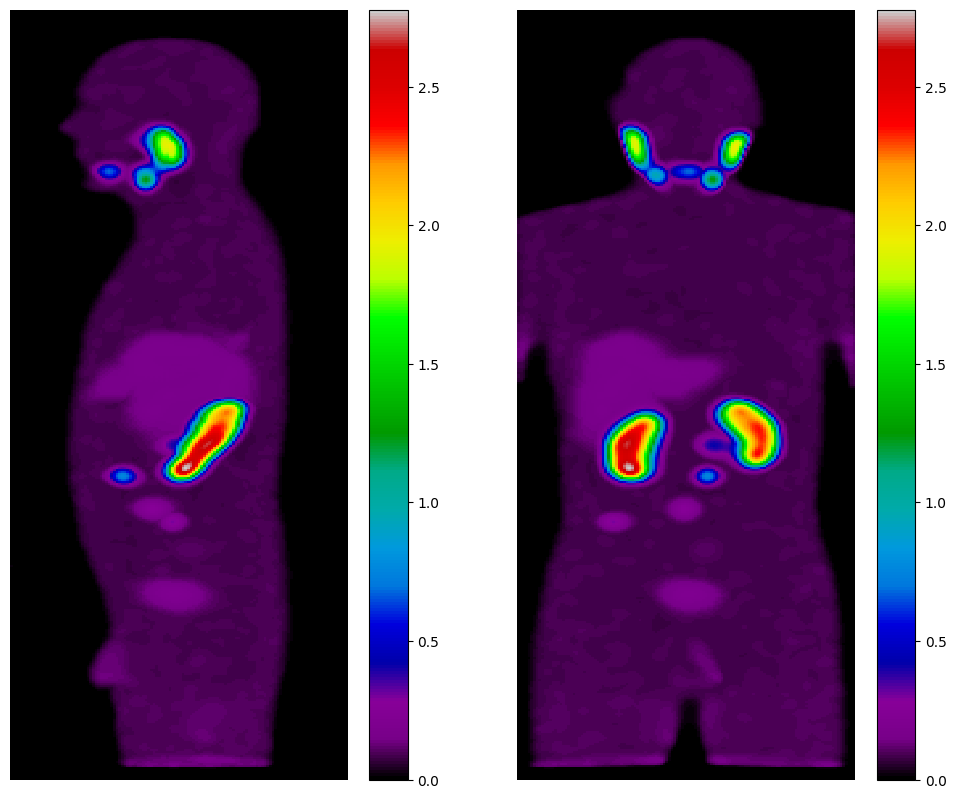

In [6]:
plt.subplots(1,2,figsize=(12,10))
plt.subplot(121)
plt.pcolormesh(reconstructed_object[0].cpu().numpy().max(axis=0).T, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.subplot(122)
plt.pcolormesh(reconstructed_object[0].cpu().numpy().max(axis=1).T, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')

## The Methodical Way

The `get_SPECT_recon_algorithm_simind` is function that allows convenient formation of a reconstruction algorithm for `simind` data. We can also build the reconstruction algorithm from scratch, explicitly defining the components of the system matrix.

In [7]:
object_meta, image_meta, projections = simind.get_projections(
    os.path.join(path, 'body1t2ew6_tot_w2.hdr')
    )

Open the estimate for the scatter using the `get_scatter_from_TEW` method:

In [8]:
scatter = simind.get_scatter_from_TEW(
    headerfile_peak = os.path.join(path, 'body1t2ew6_tot_w2.hdr'),
    headerfile_lower = os.path.join(path, 'body1t2ew6_tot_w1.hdr'),
    headerfile_upper = os.path.join(path, 'body1t2ew6_tot_w3.hdr')
)

The CT data is loaded in a similar fashion

In [9]:
CT = simind.get_atteuation_map(os.path.join(path, 'body1.hct'))

As usual, it is good practice to ensure the CT and projections are aligned
* Note: the sagittal view of the CT is the mirror of the projection at 90 degrees; this has to do with the coordinate system defined in the manual.

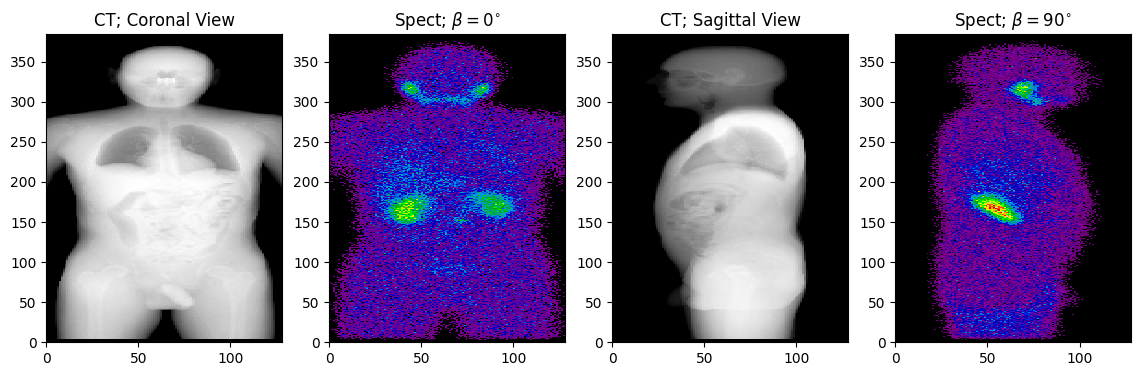

In [10]:
plt.subplots(1, 4, figsize=(14,4))
plt.subplot(141)
plt.pcolormesh(CT[0].sum(axis=1).T, cmap='Greys_r')
plt.title('CT; Coronal View')
plt.subplot(142)
plt.pcolormesh(projections[0][0].T, cmap='nipy_spectral')
plt.title(r'Spect; $\beta=0^{\circ}$')
plt.subplot(143)
plt.pcolormesh(CT[0].sum(axis=0).T, cmap='Greys_r')
plt.title('CT; Sagittal View')
plt.subplot(144)
plt.pcolormesh(projections[0][30].T, cmap='nipy_spectral')
plt.title(r'Spect; $\beta=90^{\circ}$')
plt.show()

Now we need to define all the required mappings to model $g = Hf$

Attenuation Modeling

* This transform corresponds to a mapping $A_i(\theta)$ as specified in the user manual and takes in an object/corresponding projection angle and returns a modified object

In [11]:
att_transform = SPECTAttenuationTransform(CT)

PSF Modeling

* This transform corresponds to a mapping $A_i(\theta)$ as specified in the users manual. The `collimator_slope` and `collimator_intercept` are parameters that need to be explicitly known for a given scanner. They can be obtained, for example, by fitting Gaussian profiles to a point source at varying distances from the detector surface, and determining $\sigma(z)=(\text{collimator slope})\cdot z + \text{collimator intercept}$

In [12]:
psf_meta = PSFMeta(collimator_slope = 0.03013, collimator_intercept = 0.1967)
psf_transform = SPECTPSFTransform(psf_meta)

Now we can build our system matrix $H$:

* The forward method `system_matrix.forward(f)` corresponds to $Hf$ where $H = \sum_{\theta} P(\theta)A_1(\theta)A_2(\theta) \otimes \hat{\theta}$
* The backward method `system_matrix.backward(g)` corresponds to $H^T g$ 

In [13]:
system_matrix = SystemMatrix(
    obj2obj_transforms = [att_transform,psf_transform],
    im2im_transforms = [],
    object_meta = object_meta,
    image_meta = image_meta)

We can also define the Baysian Prior:

In [14]:
prior = RelativeDifferencePrior(beta=1, gamma=5)

We'll use these FP/BP nets to create the reconstruction algorithm:

In [15]:
reconstruction_algorithm = OSEMBSR(
    image = projections,
    system_matrix = system_matrix,
    scatter = scatter,
    prior = prior)

Get the reconstructed object

In [16]:
reconstructed_object = reconstruction_algorithm (n_iters=10, n_subsets=8)

Plot the reconstructed object next to the CT.
* The reconstructed object has units of counts, and would need to be adjusted by a proportionality factor if one wants to obtain units of MBq

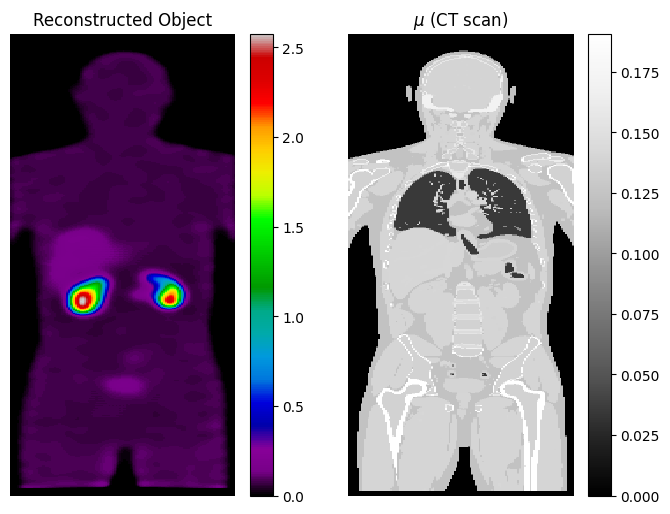

In [17]:
plt.subplots(1,2,figsize=(8,6))
plt.subplot(121)
plt.pcolormesh(reconstructed_object[0].cpu()[:,70].T, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.title('Reconstructed Object')
plt.subplot(122)
plt.pcolormesh(CT[0][:,70].T, cmap='Greys_r')
plt.colorbar()
plt.axis('off')
plt.title('$\mu$ (CT scan)')
plt.show()